# Covid-19 tweets

In [18]:
import os, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import scipy.stats as stats

plt.rcParams["font.family"] = "CMU Sans Serif"

colors = {'blue':'#00274C','teal':'#3B7EA1',
          'lavender':'#946eb7','crimson':'#8c1515',
          'orange':'#e77500','green':'#0c5449'}

golden = (1 + 5 ** 0.5) / 2

In [2]:
cols = ['id','created_at','source','state','vader','flair']
# other possible columns:
#  'retweet_count', 'user_loc_display', 'text','coordinates', 'user_loc',
#  'user_lat', 'user_lon', 'user_loc_display'

df = pd.DataFrame(columns=cols)

for file_name in os.listdir('data/'):
    if 'sentiments_' in file_name:
        df = pd.concat(
            [df,pd.read_csv('data/'+file_name,low_memory=False,usecols=cols)]
        )

n = df.shape[0]
df = df[~(df['vader'].isna()|df['flair'].isna())].copy()
print(f'Dropping {n - df.shape[0]} rows with NaN for sentiment scores')

Dropping 6 rows with NaN for sentiment scores


## Data visualization

findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.


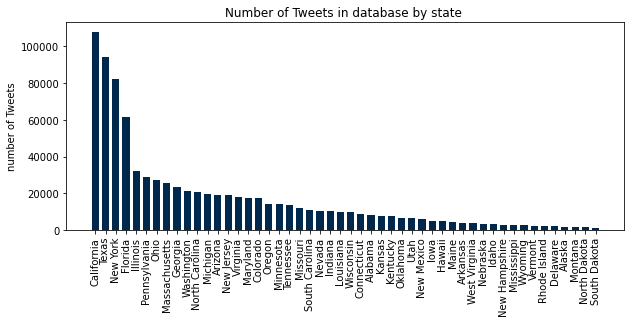

In [19]:
state_counts = df['state'].value_counts(normalize=False).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,10/golden**2))

ax.bar(state_counts.index, state_counts.values, align='center',width=0.7,color=colors['blue'])
#ax.set_yticklabels(people)
ax.set_ylabel('number of Tweets')
ax.set_title('Number of Tweets in database by state ')
plt.xticks(rotation=90)
plt.savefig('tweets_by_state.png',bbox_inches='tight',dpi=400)
plt.show()

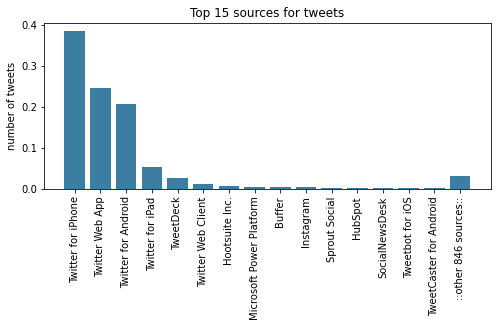

In [20]:
topn = 15

data_sources = df['source'].value_counts(normalize=True).sort_values(ascending=False)

top_sources = data_sources.iloc[:topn]



top_sources[f'::other {data_sources.iloc[topn:].shape[0]} sources::'] = data_sources.iloc[20:].sum()

fig, ax = plt.subplots(figsize=(8,8/golden**2))
ax.bar(top_sources.index, top_sources.values, align='center',color=colors['teal'])
ax.set_ylabel('number of tweets')
ax.set_title(f'Top {topn} sources for tweets')
plt.xticks(rotation=90)
plt.savefig('tweets_by_source.png',bbox_inches='tight',dpi=400)
plt.show()

## calculation

In [5]:
df['vader zscore']= stats.zscore(df['vader'],nan_policy='omit')
df['flair zscore']= stats.zscore(df['flair'],nan_policy='omit')

df['aggregate']= df['vader zscore']+df['flair zscore']

df['dayofyear'] = pd.to_datetime(df['created_at']).dt.dayofyear


def doy_to_date(dayofyear):
    return datetime.datetime.strptime('2020 '+str(dayofyear), '%Y %j').strftime('%b %d')


/home/greg/anaconda3/envs/covidtweets/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/greg/anaconda3/envs/covidtweets/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


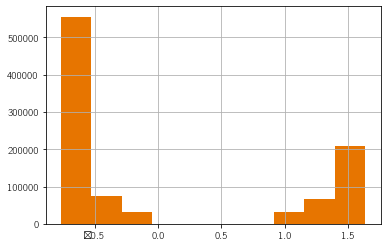

In [6]:
df['flair zscore'].hist(color=colors['orange'])

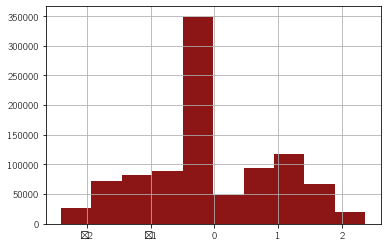

In [7]:
df['vader zscore'].hist(color=colors['crimson'])

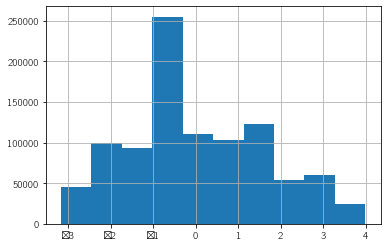

In [8]:
df['aggregate'].hist()

In [9]:
stats.spearmanr(df['vader zscore'].values,df['flair zscore'].values)

SpearmanrResult(correlation=0.3411985308662265, pvalue=0.0)

## plotting covid twitter sentiment from top 8 states with most tweets

/home/greg/anaconda3/envs/covidtweets/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/greg/anaconda3/envs/covidtweets/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


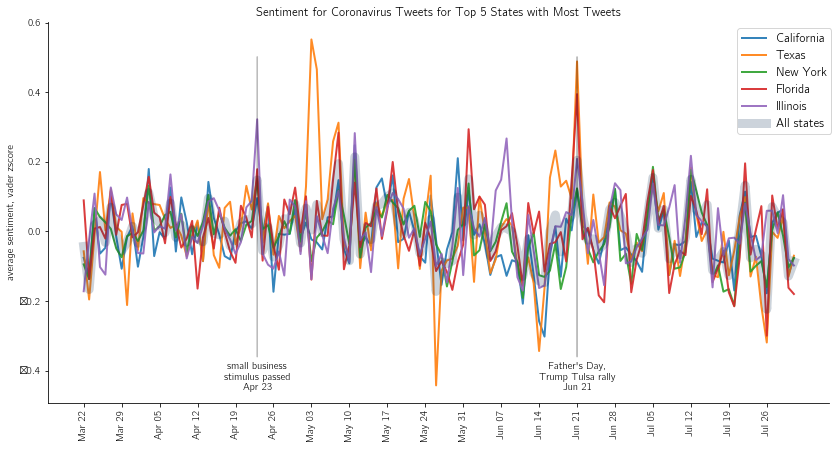

In [10]:
# choose 1 metric
metrics = ['vader zscore','flair zscore','aggregate']
metric = metrics[0]

fig, ax = plt.subplots(figsize=(14, 7))


df_temp = df[['state',metric,'dayofyear']].groupby(['state','dayofyear']).mean()

sentiment_by_day_and_state = df_temp.reset_index()\
    .pivot(index='state',columns='dayofyear',values=metric)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


for state in state_counts.index[:5]:
    st_data = sentiment_by_day_and_state.loc[state]
    ax.plot(st_data.index, st_data.values,'-',lw=2,alpha=0.9,label=state)

overall = df[['dayofyear',metric]].groupby('dayofyear').mean()
ax.plot(overall.index,overall.values,'-',
        lw=9,color=colors['blue'],alpha=0.2,
        label='All states')

#spl = UnivariateSpline(overall.index, overall.values)
#spl.set_smoothing_factor(1.5)
#xs = np.linspace(min(overall.index),max(overall.index),100)
#plt.plot(xs, spl(xs), 'b', lw=20,alpha=0.1,label='\n    All states\n')

ticks = list(sentiment_by_day_and_state.loc['Michigan'].index)[::7]


fontP = FontProperties()
fontP.set_size('large')
ax.legend(bbox_to_anchor=(1.01, 1),prop=fontP)



def custom_annotation(text, dayofyear,
                      textheight = ax.get_ylim()[0]*0.85,
                      tipheight  = ax.get_ylim()[1]*0.85):    
    ax.annotate(text+'\n'+doy_to_date(dayofyear), 
                xy=(dayofyear, tipheight), 
                xytext=(dayofyear, textheight),
                arrowprops=dict(facecolor='black', alpha=0.25,width=0.05,
                                headwidth=0.05,headlength=1,shrink=0.01),
                horizontalalignment='center',verticalalignment='center'
               )

valley,peak = [0.85*x for x in ax.get_ylim()]
#custom_annotation('federal stimulus\npassed', 87)
custom_annotation('small business\nstimulus passed',114)
#custom_annotation('',124)
#custom_annotation('',147,textheight=peak,tipheight=valley)
custom_annotation('Father\'s Day,\nTrump Tulsa rally',173)


plt.xticks(ticks=ticks,labels = [doy_to_date(tick) for tick in ticks],rotation=90)
plt.ylabel(f'average sentiment, {metric}')
plt.title('Sentiment for Coronavirus Tweets for Top 5 States with Most Tweets')

plt.show()

In [11]:
# color_dict = {'New York':'#57068c','Texas':'#BF5700',
#               'California':'#003262','Illinois':'#E84A27','Florida':'#005030'}

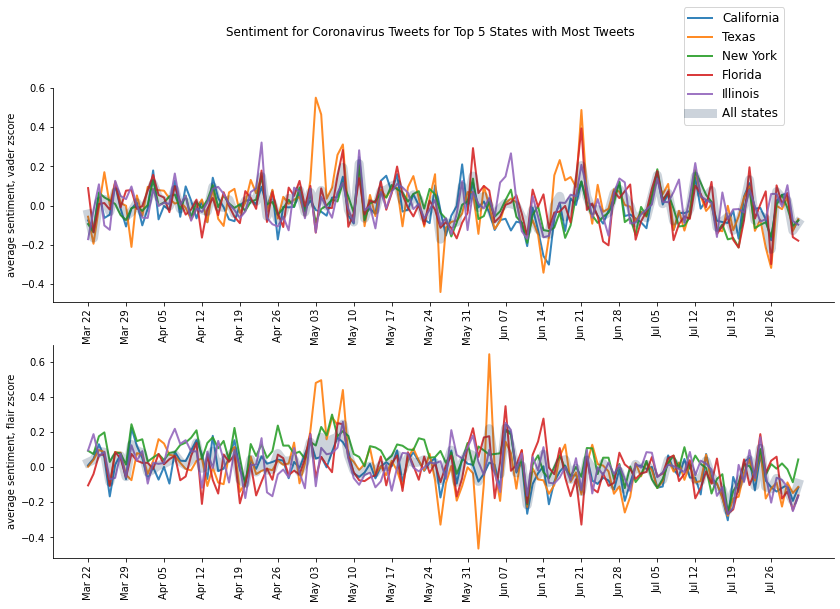

In [21]:
# choose 1 metric

# plotting

def doy_to_date(dayofyear):
    return datetime.datetime.strptime('2020 '+str(dayofyear), '%Y %j').strftime('%b %d')


fig, axs = plt.subplots(2,sharex=False,figsize=(14, 14/golden))

plt.setp(axs,xticks=ticks,xticklabels = [doy_to_date(tick) for tick in ticks])

plt.xticks(rotation=90)

metrics = ['vader zscore','flair zscore','aggregate']

for i in range(2):
    
    metric = metrics[i]
    ax = axs[i]
    
    ax.tick_params(axis="x", rotation=90) 

    df_temp = df[['state',metric,'dayofyear']].groupby(['state','dayofyear']).mean()

    sentiment_by_day_and_state = df_temp.reset_index()\
        .pivot(index='state',columns='dayofyear',values=metric)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for state in state_counts.index[:5]:
        st_data = sentiment_by_day_and_state.loc[state]
        ax.plot(st_data.index, st_data.values,'-',lw=2,alpha=0.9,label=state)

    overall = df[['dayofyear',metric]].groupby('dayofyear').mean()
    ax.plot(overall.index,overall.values,'-',
            lw=9,color=colors['blue'],alpha=0.2,
            label='All states')

    ticks = list(sentiment_by_day_and_state.loc['Michigan'].index)[::7]

    fontP = FontProperties()
    fontP.set_size('large')
    
    if i==0:
        ax.legend(bbox_to_anchor=(0.8, 0.8),prop=fontP)


#     def custom_annotation(text, dayofyear,
#                           textheight = ax.get_ylim()[0]*0.85,
#                           tipheight  = ax.get_ylim()[1]*0.85):    
#         ax.annotate(text+'\n'+doy_to_date(dayofyear), 
#                     xy=(dayofyear, tipheight), 
#                     xytext=(dayofyear, textheight),
#                     arrowprops=dict(facecolor='black', alpha=0.25,width=0.05,
#                                     headwidth=0.05,headlength=1,shrink=0.01),
#                     horizontalalignment='center',verticalalignment='center'
#                    )

#     valley,peak = [0.85*x for x in ax.get_ylim()]
#     #custom_annotation('federal stimulus\npassed', 87)
#     custom_annotation('small business\nstimulus passed',114)
#     #custom_annotation('',124)
#     #custom_annotation('',147,textheight=peak,tipheight=valley)
#     custom_annotation('Father\'s Day,\nTrump Tulsa rally',173)

    ax.set(ylabel=f'average sentiment, {metric}')


plt.suptitle('Sentiment for Coronavirus Tweets for Top 5 States with Most Tweets')

plt.savefig('top5states.png',bbox_inches='tight',dpi=400)

plt.show()

## Red, Blue, Swing

In [13]:
# via https://en.wikipedia.org/wiki/2016_United_States_presidential_election
# swing states have margin within 5.5% in the 2016 election
blue = ['Hawaii', 'California', 'Massachusetts', 'Maryland', 
        'Vermont', 'New York', 'Illinois', 'Washington', 'Rhode Island', 
        'New Jersey', 'Connecticut', 'Delaware', 'Oregon', 'New Mexico']
swing = ['Virginia', 'Colorado', 'Maine', 'Nevada', 'Minnesota', 
         'New Hampshire', 'Michigan', 'Pennsylvania', 'Wisconsin',
         'Florida', 'Arizona', 'North Carolina', 'Georgia']
red = ['Wyoming', 'Indiana', 'Nebraska', 'Tennessee', 'Kentucky',
       'Ohio', 'Mississippi', 'Oklahoma', 'South Dakota', 'Idaho',
       'West Virginia', 'Utah', 'Alabama', 'Montana', 'Alaska', 'Texas',
       'Kansas', 'Iowa', 'North Dakota', 'South Carolina', 'Arkansas',
       'Louisiana', 'Missouri']

assert len(set(blue)|set(swing)|set(red))==50

df['politics'] = None
df.loc[df['state'].isin(swing),'politics'] = 'swing'
df.loc[df['state'].isin(red),'politics'] = 'red'
df.loc[df['state'].isin(blue),'politics'] = 'blue'

peaks = {}

for pol in ['red','blue']:
    for metric in ['flair','vader']:
        overall = df[df['politics']==pol][['dayofyear',f'{metric} zscore']].groupby('dayofyear').mean().rolling(3).mean()
        peaks[pol+'/'+metric] = overall[(overall==overall.rolling(7).max()).values].index
    peaks[pol] = list(set(peaks[f'{pol}/flair'])&set(peaks[f'{pol}/vader']))

print(
    "7-day rolling peak sentiment shared by both flair and vader:",
    "\nfor  red states:", len(peaks['red']),
    "\nfor blue states:", len(peaks['blue'])
)

7-day rolling peak sentiment shared by both flair and vader: 
for  red states: 9 
for blue states: 6


In [14]:
df['politics'].value_counts()

blue     344784
swing    249660
red      243982
Name: politics, dtype: int64

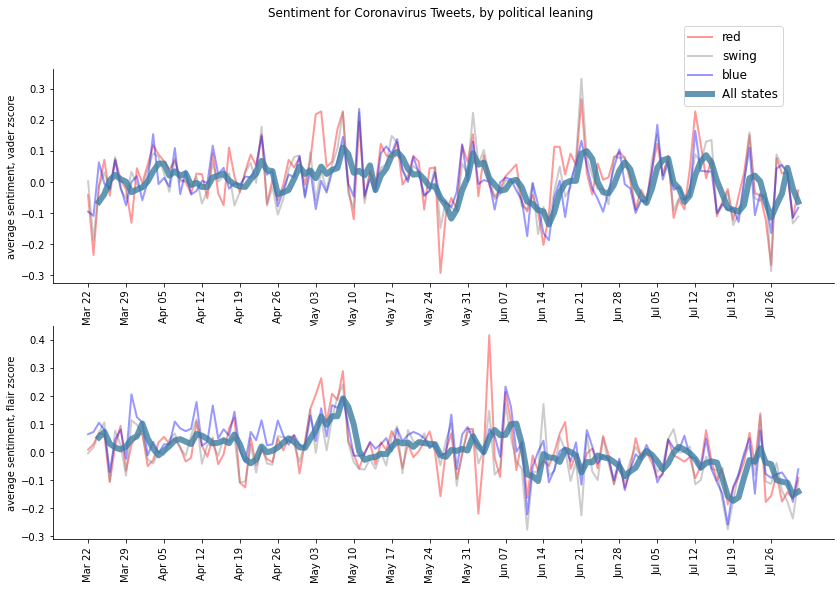

In [22]:
ticks = sorted(df['dayofyear'].unique())[::7]

fig, axs = plt.subplots(2,sharex=False,figsize=(14, 14/golden))

plt.setp(axs,xticks=ticks,xticklabels = [doy_to_date(tick) for tick in ticks])

plt.xticks(rotation=90)

metrics = ['vader zscore','flair zscore']

for i in range(2):
    
    metric = metrics[i]
    ax = axs[i]
    
    ax.tick_params(axis="x", rotation=90)
    
    df_temp = df[['politics',metric,'dayofyear']].groupby(['politics','dayofyear']).mean()

    sentiment_by_day_and_pol = df_temp.reset_index()\
        .pivot(index='politics',columns='dayofyear',values=metric)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for pol in ['red','swing','blue']:
        color = pol
        if pol == 'swing':
            color = 'gray'
        pol_data = sentiment_by_day_and_pol.loc[pol]
        ax.plot(pol_data.index, pol_data.values,'-',lw=2,alpha=0.4,
                label=pol,color=color)

    overall = df[['dayofyear',metric]].groupby('dayofyear').mean().rolling(3).mean()
    ax.plot(overall.index,overall.values,'-',
            lw=6,color=colors['teal'],alpha=0.8,
            label='All states')

    ticks = list(sentiment_by_day_and_pol.loc['swing'].index)[::7]

    fontP = FontProperties()
    fontP.set_size('large')
    
    if i==0:
        ax.legend(bbox_to_anchor=(0.8, 0.8),prop=fontP)

    ax.set(ylabel=f'average sentiment, {metric}')
    
#     def custom_annotation(text, dayofyear,
#                           textheight = ax.get_ylim()[0]*1,
#                           tipheight  = ax.get_ylim()[1]*1):    
#         ax.annotate(text,#+'\n'+doy_to_date(dayofyear), 
#                     xy=(dayofyear, tipheight), 
#                     xytext=(dayofyear, textheight),
#                     arrowprops=dict(facecolor='black', alpha=0.25,width=0.05,
#                                     headwidth=0.05,headlength=1,shrink=0.01),
#                     horizontalalignment='center',verticalalignment='center'
#                    )
    
#     for p in list(set(peaks['blue'])|set(peaks['red'])):
#         custom_annotation('',p)


plt.suptitle('Sentiment for Coronavirus Tweets, by political leaning')
plt.savefig('by_politics.png',bbox_inches='tight',dpi=400)
plt.show()

## Map